In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
import time

In [16]:
#Input parameters
width = 107 #domain x
height = 107 #domain y

cell_dim = 7.6 #dimension of the cells which the circles are initially inside
R_mean = 3.5 #circles mean
R_std = 0.000000001 #standard deviation of circles

#Calculate the distribution from a Weibull distribution
Weibull_shape = 1.378
Weibull_scale = 0.2292


In [17]:
# Step 1: Arrange the circles in a regular order
y = 0
counter_y = 0
n_fibers=1;
Circ_loc = np.empty((0,2), float)
Radius = np.array([])
pi = 3.14159265358
while (y+3*cell_dim/2 <= height):
    y = cell_dim/2+counter_y*cell_dim
    counter_y = counter_y+1
    counter_x = 0
    x = 0
    while (x+3*cell_dim/2 <= width):
        Radius = np.append(Radius, np.random.normal(R_mean, R_std))
        if (counter_y%2==0): #even rows
            x = cell_dim + counter_x*cell_dim
        else: #odd rows
            x = cell_dim/2 + counter_x*cell_dim
        counter_x = counter_x+1
        Circ_loc = np.append(Circ_loc, np.array([[x, y]]), axis=0)
        n_fibers=n_fibers+1
# calculating the volume fraction of circles
area1 = height*width
area2 = np.sum(pi*Radius**2)
print('Circles volume fraction  = ',100*area2/area1,'%',sep='')

Circles volume fraction  = 63.530198192017465%


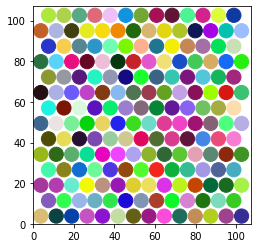

In [18]:
fig, ax = plt.subplots()
for i in range(Radius.shape[0]):
    fiber_color=(np.random.random(), np.random.random(), np.random.random())
    circle = plt.Circle((Circ_loc[i,]), Radius[i], color=fiber_color)
    ax.add_artist(circle)
ax.set_xlim((0, width))
ax.set_ylim((0, height))
# fig.set_size_inches(5,5)
plt.gca().set_aspect(1)

In [19]:
#Distance matrix without for loop
def Distance_Matrix(Circle, Radiuss):
    D_x = -2*np.dot(Circle[:,0][:,np.newaxis],Circle[:,0][np.newaxis,:])+Circle[:,0][:,np.newaxis]**2+Circle[:,0][np.newaxis,:]**2
    D_y = -2*np.dot(Circle[:,1][:,np.newaxis],Circle[:,1][np.newaxis,:])+Circle[:,1][:,np.newaxis]**2+Circle[:,1][np.newaxis,:]**2
    D = np.sqrt(D_x+D_y) - Radiuss[np.newaxis,:] - Radiuss[:,np.newaxis]
    np.fill_diagonal(D, 1e10)
    min_D = np.min(D,axis=0)
    return D, min_D

In [20]:
def KL_Divergence(dist1,dist2,start_point, end_point, n_bins):    
    bin_length = (end_point-start_point)/n_bins
    edges = np.arange(start_point, end_point, bin_length)
    hist1 = np.histogram(dist1,edges)[0]/np.shape(dist1)[0]
    hist2 = np.histogram(dist2,edges)[0]/np.shape(dist2)[0]
    hist1[hist1==0] = 1e-5 #to avoid division by 0 
    hist2[hist2==0] = 1e-5 #to avoid division by 0
    KL = np.dot(hist1,np.log(hist1/hist2))
    return KL

In [21]:
#Fix this on later... for values smaller than zero, must output zero! or, if x<0 -> x=0
def Weibull_dist(shape,scale,start_point, end_point, n_points):
    size = (end_point-start_point)/n_points
    x = np.arange(start_point, end_point, size)
    PDF_dist = shape/scale*((x/scale)**(shape-1))*(np.e**(-(x/scale)**shape))
    return PDF_dist

In [22]:
def CDF_plots(data1,data2):
    # Data1:
    data1 = np.append(data1,0)
    sorted_data1 = np.sort(data1)
    CDF1 = np.arange(np.size(sorted_data1))
    CDF1 = CDF1/np.max(CDF1)
    # Data2:
    data2 = np.append(data2,0)
    sorted_data2 = np.sort(data2)
    CDF2 = np.arange(np.size(sorted_data2))
    CDF2 = CDF2/np.max(CDF2)
    plt.plot(sorted_data1, CDF1,sorted_data2, CDF2)
    plt.legend(('Target distribution', 'Generated distribution'),fontsize='x-large')
    plt.show()    

In [23]:
Distance,NN_distance = Distance_Matrix(Circ_loc,Radius)

In [24]:
n = 50000   # number of samples
k = 0.65    # scale
lam = 0.08  # shape

NN_distance_target = weibull_min.rvs(k, loc=0, scale=lam, size=n)

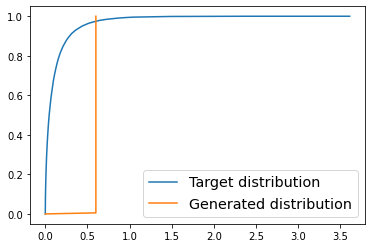

In [25]:
CDF_plots(NN_distance_target,NN_distance)

In [26]:
KL = KL_Divergence(NN_distance_target,NN_distance,0,2,30)
print('Initial KL divergence = ',KL)

Initial KL divergence =  9.89420177759446


In [27]:
#STEP 2

min_fiber_dist = 0.0
counter_final = 10000
counter = 0

while (counter < counter_final):    
    sigma = np.random.random_sample()
    #randomly select one circle
    j = np.random.randint(np.shape(Radius)[0])
    #randomly choose a perturbation
    Xr = np.random.normal(0.0, sigma)
    Yr = np.random.normal(0.0, sigma)
    #add perturbation
    Circ_loc[j,0] = Circ_loc[j,0]+Xr
    Circ_loc[j,1] = Circ_loc[j,1]+Yr
    #check if there is any intersection between the perturbed circle and
    #boundaries/other circles
    Distance,NN_distance = Distance_Matrix(Circ_loc, Radius)
    n_circ_int = np.sum((Distance-min_fiber_dist)<0)
    counter = counter+1
    if (n_circ_int>0 or  Circ_loc[j,0]>(width - Radius[j]) or Circ_loc[j,1]>(height - Radius[j]) or Circ_loc[j,0]< Radius[j] or Circ_loc[j,1]<Radius[j]):
        Circ_loc[j,0] = Circ_loc[j,0]-Xr
        Circ_loc[j,1] = Circ_loc[j,1]-Yr
        counter = counter-1
    if (counter%(counter_final/100)==0):
        print('\r','Initial shuffling progress = ',counter*100/counter_final,'%',sep='', end='')

Initial shuffling progress = 100.0%

 Accepted step =  143 ----> KL divergence =  0.017206059328730552

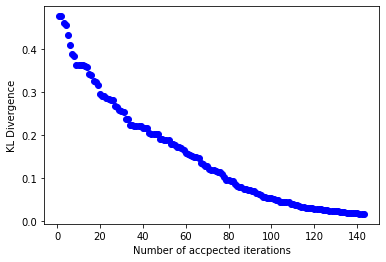

In [28]:
#STEP 3
current_time = time.time()
iteration_time=60 #this time depends of the number of fibers in the domain
final_time = current_time+60
fig = plt.gcf()
fig.show()
fig.canvas.draw()
step_couter = 1
while (current_time < final_time):
    current_time = time.time()
    sigma = np.random.random_sample()
    accept_perturbation = True
    #randomly select one circle
    j = np.random.randint(np.shape(Radius)[0])
    #randomly choose a perturbation
    Xr = np.random.normal(0.0, sigma)
    Yr = np.random.normal(0.0, sigma)
    #add perturbation
    Circ_loc[j,0] = Circ_loc[j,0]+Xr
    Circ_loc[j,1] = Circ_loc[j,1]+Yr
    #check if there is any intersection between the perturbed circle and
    #boundaries/other circles
    Distance,NN_distance = Distance_Matrix(Circ_loc, Radius)
    n_circ_int = np.sum((Distance-min_fiber_dist)<0)
    counter = counter+1
    if (n_circ_int>0 or  Circ_loc[j,0]>(width - Radius[j]) or Circ_loc[j,1]>(height - Radius[j]) or Circ_loc[j,0]< Radius[j] or Circ_loc[j,1]<Radius[j]):
        accept_perturbation = False
        Circ_loc[j,0] = Circ_loc[j,0]-Xr
        Circ_loc[j,1] = Circ_loc[j,1]-Yr
    #the distributions distance is calculated only when there is no penetration!
    if (accept_perturbation): 
        new_KL = KL_Divergence(NN_distance_target,NN_distance,0,2,30)
        Delta = new_KL - KL
        if (Delta<0):
            KL = new_KL
            plt.plot(step_couter,KL,'bo')
            plt.ylabel('KL Divergence')
            plt.xlabel('Number of accpected iterations')
            fig.canvas.draw()
            print('\r','Accepted step = ',step_couter, '---->','KL divergence = ',KL, end='')
            step_couter=step_couter+1
        else:
            Circ_loc[j,0] = Circ_loc[j,0]-Xr
            Circ_loc[j,1] = Circ_loc[j,1]-Yr

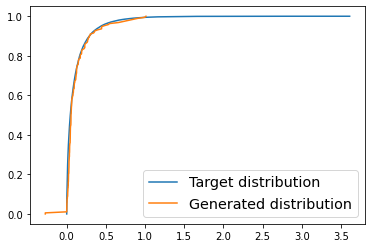

In [29]:
CDF_plots(NN_distance_target,NN_distance)

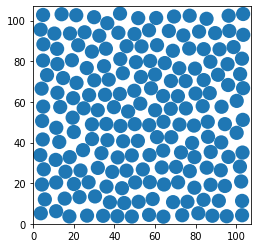

In [30]:
fig, ax = plt.subplots()
for i in range(Radius.shape[0]):
    fiber_color=(np.random.random(), np.random.random(), np.random.random())
    circle = plt.Circle((Circ_loc[i,]), Radius[i])
    ax.add_artist(circle)
ax.set_xlim((0, width))
ax.set_ylim((0, height))
# fig.set_size_inches(5,5)
plt.gca().set_aspect(1)